# Acelerando aplicações com CUDA C/C++

* CUDA é um acrônimo para Compute Unified Device Architecture.
* É uma API criada pela NVIDIA para Computação Paralela em suas GPUS, portanto precisamos de uma GPU da NVIDIA para programar em CUDA. Entretanto, existem ferramentas que tentam integrar GPU's da AMD com o código CUDA, como por exemplo: [ZLUDA](https://github.com/vosen/ZLUDA?authuser=0)
* Um sistema acelerado, também conhecido como sistema heterogêneo, são sistemas compostos por uma CPU e uma GPU;

* Para obter informações da sua GPU NVIDIA que rodará seu código CUDA, utilize a CLI:

In [ ]:
!nvidia-smi

# CPU vs GPU
* Códigos rodados apenas na CPU geralmente são serializados, isto é, a chamada de uma função fará uma série de instruções sequencialmente. Quando trabalhamos com CUDA, podemos ter processamento em paralelo nos dados por parte da GPU, enquanto a CPU trabalha com outros dados, o que nos faz ganhar tempo. Para armazenar dados na GPU e ganharmos acesso a este processamento paralelo, chamamos cudaMallocManaged(). É importante ressaltar que trabalhar na GPU é um processo assíncrono, já que a CPU trabalha ao mesmo tempo. Portanto, para sincronizá-los, chamamos cudaDeviceSynchronize() para que a CPU seja sincronizada com a GPU, isto é, aguardar a GPU terminar o trabalho dela. Depois disso podemos por exemplo acessar os dados processados pela GPU na CPU novamente.

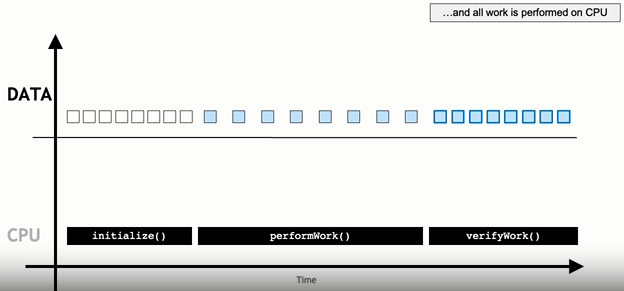

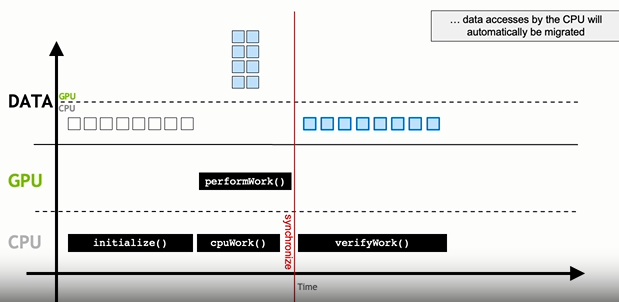

# Escrevendo códigos para GPU

* .cu é a extensão para arquivos CUDA

```cpp
void CPUFunction()
{
  printf("This function is defined to run on the CPU.\n");
}

__global__ void GPUFunction()
{
  printf("This function is defined to run on the GPU.\n");
}

int main()
{
  CPUFunction();

  GPUFunction<<<1, 1>>>();
  cudaDeviceSynchronize();
}
```

* O código acima possui duas funções: a primeira que será rodada na CPU e a segunda que será executada na GPU.
* A palavra-chave ```__global__``` indica que a função será rodada na GPU e pode ser invocada globalmente, o que neste contexto significa CPU e GPU.
* Geralmente, o código rodado na CPU é chamado de **HOST** code e o código rodado na GPU é chamado de **DEVICE** code.
* Quando uma função é chamada para ser executada na GPU, isto é, possui o pre-fixo __global__, chamamos esta função de **kernel** que é **inicializado/launched**.
* ``` GPUFunction<<<1, 1>>>(); ```
* ```<<< ... >>>``` através desta sintaxe colocamos as configurações de execução deste kernel, ou função da GPU, o primeiro parâmetro é o número de blocos e o segundo parâmetro é a quantidade de threads em cada bloco.
* ``` cudaDeviceSynchronize(); ```
* Diferente do código padrão de C/C++, inicializar kernels é uma tarefa assíncrona: o código da CPU continuará executando sem esperar o kernel finalizar.
* A chamada para ``` cudaDeviceSynchronize() ``` faz com que a CPU espere até o código executado na GPU termine para continuar.

# NVCC: NVIDIA CUDA Compiler
* Para compilar e roda seu programa em CUDA, utilizamos o ```nvcc``` que é bem parecido com o ```gcc```:

```nvcc -o out some-CUDA.cu -run```
* em que:
* some-CUDA.cu é o nosso arquivo CUDA
* out será o nome do nosso programa compilado
* run para executá-lo imediatamente
* OBS: para códigos não CUDA (host code), o nvcc chama o gcc para compilar, trabalhando apenas nos códigos CUDA (device code) (__global__)

In [ ]:
# Exemplo
!nvcc -o hello-gpu module1/hello-gpu.cu -run

# Recapitulando

* O trabalho da GPU é feito em paralelo.
* O trabalho de uma GPU é executado em uma thread.
* Muitas threads em uam GPU rodam paralelamente
* Uma coleção de threads é um bloco.
* Uma coleção de blocos é um grid.
* Funções da GPU são chamadas de kernel.
* Kernels são inicializados com uma configuração de execução. ``` <<< ... >>>```
* A configuração de execução define a quantidade de blocos no grid, como primeiro parâmetro, e a quantidade de threads em cada bloco, como segundo parâmetro.
* Todo bloco em um grid possui a mesma quantidade de threads.

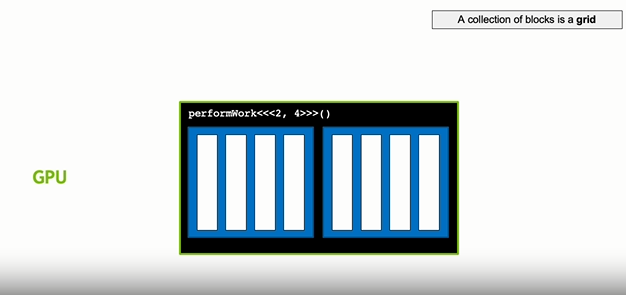

* Em branco, temos as threads
* Em azul, temos os blocos
* Em preto com bordas verdes, temos o grid

# Inicializando Kernels em paralelo

* ```<<< NUMBER_OF_BLOCKS, NUMBER_OF_THREADS_PER_BLOCK>>>```
* someKernel<<<1, 1>>>() é um kernel configurado para rodar em um único bloco, que contém uma única thread, portanto rodará 1 vez.
* someKernel<<<1, 10>>>() é um kernel configurado para rodar em um único bloco,
que contêm dez threads, portanto rodará 10 vezes.
* someKernel<<<10, 1>>>() é um kernel configurado para rodar em dez blocos, o qual cada um contêm 10 threads, portanto rodará 10 vezes.
* someKernel<<<10, 10>>>() é um kernel configurado para rodar em dez blocos, o qual cada um contêm 10 threads, portanto rodará 100 vezes.


* Exemplo em:
!nvcc -o first-parallel module1/first-parallel.cu -run